# **Dependencies**


In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize 
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
# Helper function 
def check(word, df):
  return df[df['tweet'].str.contains(word, case = False)]['tweet'].unique()[:10]

def unigram(df):
  uni = df['tweet'].str.split(expand = True).stack()
  return uni.value_counts().head(30)

def get_top_n_gram(data,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range).fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def word_count(x):
  return len(x.split())

def char_count(series):
  clean = series.str.replace(' ', '')
  return clean.str.len()

In [ ]:
# Mount colab
from google.colab import drive

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Dataset
dataset_url = 'https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/re_dataset.csv'
raw = pd.read_csv(dataset_url, encoding = 'latin1')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hatespeech_dataset.csv')

In [ ]:
df.head(10)

,tweet,hs
0,cowok berus melacak perhatian gue lantas remen...,1
1,telat tau edan sarap gue bergaul cigax jifla c...,0
2,kadang berpikir percaya tuhan padl jatuh berka...,0
3,ku tau matamu sipit,0
4,kaum cebong kafir dongoknya dungu,1
5,bani taplak kawan kawan,1
6,deklarasi pilihan kepala daerah aman anti hoak...,0
7,gue selesai re watch aldnoah zero kampret kara...,0
8,admin belanja poterbaik nak ais kepal milo ais...,0
9,enak ngewe,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   13112 non-null  object
 1   hs      13169 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 205.9+ KB


In [ ]:
# Small cleaning
df = df.dropna()
df['tweet'] = df['tweet'].astype(str) 

<ipython-input-7-2b6cd3af8553>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet'] = df['tweet'].astype(str)


# **Explore**

In [ ]:
# Word count
wordcount = df['tweet'].str.split(expand = True).stack().nunique()
wordcount

18706

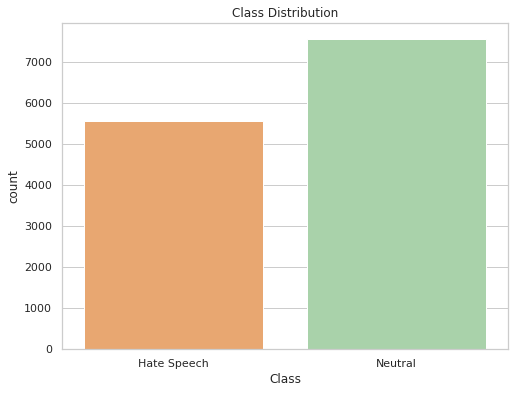

In [ ]:
# Class Distribution
df['class'] = df['hs'].map({1: 'Hate Speech', 0:'Neutral'})
sns.set_theme(style="whitegrid")
palette =  sns.color_palette('Spectral')
palettes = [palette[1], palette[4]]
fig, ax  = plt.subplots(figsize = (8,6))
sns.countplot(x = 'class',  data = df, palette = palettes)
ax.set_xlabel('Class')
plt.title("Class Distribution")
plt.show()

Classes is **slightly imbalanced**

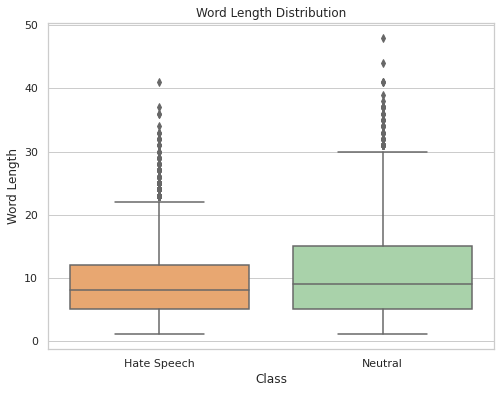

In [ ]:
# Word length
df['word_length'] = df['tweet'].apply(lambda x : word_count(x))
fig, ax  = plt.subplots(figsize = (8,6))
sns.boxplot(x = 'class', y = 'word_length',  data = df, palette = palettes)
ax.set_xlabel('Class')
ax.set_ylabel('Word Length')
plt.title("Word Length Distribution")
plt.show()

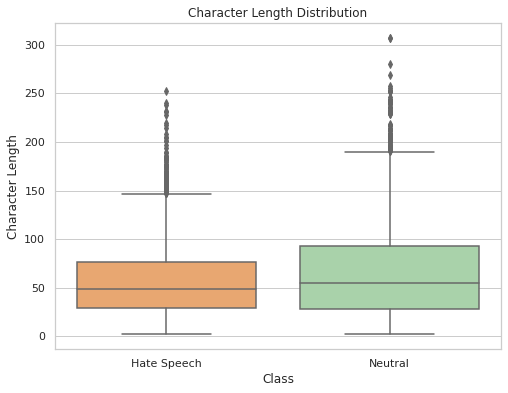

In [ ]:
# Character length
df['char_length'] = char_count(df['tweet'])
df.head()
fig, ax  = plt.subplots(figsize = (8,6))
sns.boxplot(x = 'class', y = 'char_length',  data = df, palette = palettes)
ax.set_xlabel('Class')
ax.set_ylabel('Character Length')
plt.title("Character Length Distribution")
plt.show()

There is no big difference between **hate speech** and **neutral** class in terms of characters and words count.

# **Modelling**

In [ ]:
# Modelling Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

### Train Test Split

In [ ]:
# Split Dataset
X = df['tweet'].values
y = df['hs'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify = y)

### Vectorizing

In [ ]:
# Vectorizer
tv = TfidfVectorizer()

# Fit vectorizer
tv.fit(X_train.tolist() + X_test.tolist())

# Vectorize train
v_train = tv.transform(X_train)

# Vectorize test
v_test = tv.transform(X_test)

In [ ]:
v_train.shape, v_test.shape

((10489, 18706), (2623, 18706))

We can create a boundary to use only most frequent n-percent words, but for starting, we'll use all words as features. 

### Model

In [ ]:
# Import model
from sklearn.linear_model import LogisticRegression

In [ ]:
# Logistic regression base model
clf = LogisticRegression()

In [ ]:
# Model fit
clf.fit(v_train, y_train)

LogisticRegression()

# **Model Evaluation**

In [ ]:
# evaluate a model using repeated k-fold cross-validation
yhat = clf.predict(v_test)

# round probabilities to class labels
yhat = yhat.round(0)

# calculate accuracy
acc = accuracy_score(y_test, yhat)
result = classification_report(y_test, yhat, target_names = ['Hatespeech', 'Neutral'])

# store result
print('Accuracy >%.3f' % acc)
print(result)

Accuracy >0.823
              precision    recall  f1-score   support

  Hatespeech       0.81      0.90      0.85      1513
     Neutral       0.84      0.72      0.77      1110

    accuracy                           0.82      2623
   macro avg       0.83      0.81      0.81      2623
weighted avg       0.82      0.82      0.82      2623



In [ ]:
# Evaluate every results
df_test = pd.DataFrame({'tweet':X_test, 'hs':y_test})
df_test['pred'] = yhat.flatten()
df_test['pred'] = df_test['pred'].astype(int)
fn = df_test[(df_test['hs'] == 1) & (df_test['pred'] == 0)]
tp = df_test[(df_test['hs'] == 1) & (df_test['pred'] == 1)]
tn = df_test[(df_test['hs'] == 0) & (df_test['pred'] == 0)]
fp = df_test[(df_test['hs'] == 0) & (df_test['pred'] == 1)]

`fn` = false negative,
`fp` = false positive,
`tn` = true negative,
`tp` = true positive,

In [ ]:
fn

,tweet,hs,pred
10,generasi tinja bgia pemimpin berkoar koar anti...,1,0
19,apel malang impor apel cina amerika namanya ba...,1,0
25,masyart tionghoa pancasialis orang jawa tereks...,1,0
26,by the way ratu tiru afi hinayah diundang joko...,1,0
52,bolot alias daki,1,0
...,...,...,...
2601,ih banci selotipan,1,0
2612,hai setan operator tri bannya banyaknya antusi...,1,0
2617,diketeki onta bang sombong,1,0
2619,prof fiksi menyinggung agama ramai penistaan b...,1,0


In [ ]:
fn['tweet'].unique()[:20]

array(['generasi tinja bgia pemimpin berkoar koar anti asing jaman pilihan kepala daerah selesai pilihan kepala daerah pengikutnya membela tinja asing enak',
       'apel malang impor apel cina amerika namanya bangga produk indonesia',
       'masyart tionghoa pancasialis orang jawa terekspos contoh nyata kwik ekonom ustaz felix siauw',
       'by the way ratu tiru afi hinayah diundang jokowi istana posting tiru mengancam bunuh allah',
       'bolot alias daki', 'menteri soeharto homo',
       'ah dibayari negeri mengeluh dasar bersyukur kontol',
       'bawa perasaan bang cebong pejuang bawa perasaan',
       'prabowo lolos jerat hukum anggota tim mr dijatuhi hukuman pidana penjara dkp',
       'cacat ican goblok',
       'tai doang belaganya selangit karma idol flop gue ket keras',
       'mas joko kelakuan otoriter habis rakyat rezim sadam dafi as sisi mk bro',
       'tau princess udik',
       'senang hati cewek dilepaskan mbaknya angkutan mbaknya gang bang pemerkosa kunyuk selesa

In [ ]:
raw[raw['Tweet'].str.contains('generasi tinja', case = False)]['Tweet'].unique()

array(["USER USER Ketika generasi tinja sangat bahagia pemimpin nya bisa berkoar koar anti aseng di jaman pilkada dan ketika selesai pilkada pengikutnya membela bahwa tinja nya aseng enak'"],
      dtype=object)

In [ ]:
raw[raw['Tweet'].str.contains('ratu tiru', case = False)]['Tweet'].unique()

array(['Btw si ratu tiru afi hinayah yang udah diundang jokowi ke istana posting tiru lagi yes. Ntar mengancam mau bunuh diri. Ya Alloh.'],
      dtype=object)

In [ ]:
fp

,tweet,hs,pred
13,kejang kejang bong keren dewasa malu memalukan,0,1
17,pilihan kepala daerah daerah khusus ibukota di...,0,1
63,salah alasan presiden malu in bangsa iniiii,0,1
70,maksud jor joran pinjaman ib merebut simpati r...,0,1
85,sepupu bos gue facebook namanya sin ting orang...,0,1
...,...,...,...
2596,yli tentara nasional indonesia suruh uruskan s...,0,1
2603,direct message pakai capslock bilang gue cocot,0,1
2607,terdesak kehancuran kampret kian melemah terde...,0,1
2608,doa bangsa rin islam partai keadilan sejahtera...,0,1


In [ ]:
fp['tweet'].unique()[:20]

array(['kejang kejang bong keren dewasa malu memalukan',
       'pilihan kepala daerah daerah khusus ibukota dinyatn ahok elektabilitasnya calon tunggal mengaln ahok cukong lupa media media sosial dimonopoli kebenaran maju calon gubernur daerah khusus ibukota elektabilitas ahok tergerus',
       'salah alasan presiden malu in bangsa iniiii',
       'maksud jor joran pinjaman ib merebut simpati rakyat bombardir media freepomilik indonesia isu got sulit digoreng bertransformasi rezim mainlah teknologi got tin',
       'sepupu bos gue facebook namanya sin ting orang indonesia baca nama facebook wa ng nirnya wa bilang sinting indonesia crazy tert',
       'kalimat bacot doang buktikan kalimatnya maaf kasih solusi butuh',
       'bajingan tengik',
       'ekspresi pas kaget teriak ayam ayam cebong cebong cebong',
       'il sekretariat jenderal mengaku kaget munculnya deklarasi reln mendukung mantan panglima tentara nasional indonesia ketua partai kebangkitan bangsa maju pemilihan presiden 

### Unigram

In [ ]:
# False negative unigram
unigram(fn)

indonesia    32
orang        32
presiden     30
gue          28
asing        23
agama        20
islam        19
jokowi       18
ganti        14
tai          13
partai       13
komunis      13
masuk        12
kerja        11
ulama        10
monyet       10
anak         10
cina         10
tau          10
hati          9
antek         9
nama          9
allah         8
kafir         8
rakyat        8
muslim        8
negara        8
gubernur      8
umat          8
cacat         7
dtype: int64

In [ ]:
# False positive unigram
unigram(fp)

presiden     25
indonesia    19
ganti        16
gue          16
orang        16
cina         15
rakyat       12
rezim        12
islam        12
partai       11
negara       10
jokowi       10
asing         9
bangsa        9
cebong        9
komunis       8
babi          8
bilang        8
ahok          7
mengakui      7
suka          7
bangsat       7
kampret       6
banci         6
antek         6
bajingan      6
goblok        6
biar          6
bacot         6
ulama         6
dtype: int64

In [ ]:
check('komunis', fp)

array(['untung mengakui komunis mengakui ateis',
       'maklumlah pm zionis gabung komunis',
       'hai pendukung hitler komunis', 'partai komunis indonesia bangkit',
       'komunisme fm fasisme negara komunis berpotensi bangsa fasis cina uni soviet bangsa bangsa non rusia non slavia tepatnya dibunuh',
       'warga negara indonesia bangga nini bilang soekarno partai komunis indonesia marah',
       'perpolitikan negara butuh partai komunis biar ujung kebin pemerintah minimal sosialis logikanya aset negara tangan privat',
       'tumbang sukses mengadu domba komunis liberalis pusing sang perancang perang tampil bangsa pemenang'],
      dtype=object)

### Bigram

In [ ]:
# False positive bigram
bigrams_fp = get_top_n_gram(fp['tweet'], (2,2), 20)
bigrams_fp

[('ganti presiden', 7),
 ('dewan perwakilan', 4),
 ('perwakilan rakyat', 4),
 ('daerah khusus', 3),
 ('khusus ibukota', 3),
 ('pemilihan presiden', 3),
 ('calon presiden', 3),
 ('partai komunis', 3),
 ('media sosial', 2),
 ('cebong cebong', 2),
 ('tentara nasional', 2),
 ('nasional indonesia', 2),
 ('partai kebangkitan', 2),
 ('kebangkitan bangsa', 2),
 ('bangsa maju', 2),
 ('anjing anjing', 2),
 ('rezim jokowi', 2),
 ('republik indonesia', 2),
 ('antek antek', 2),
 ('ayat sibuk', 2)]

In [ ]:
check('tenaga kerja', fp)

array(['opung tenaga kerja cina skill khusus buruh pribumi layak membangun proyek pemerintah tenaga kerja asing cina terampil labour juta lapangan pekern'],
      dtype=object)

In [ ]:
# False negative bigram
bigrams_fn = get_top_n_gram(fn['tweet'], (2,2), 20)
bigrams_fn

[('ganti presiden', 14),
 ('umat islam', 6),
 ('tenaga kerja', 6),
 ('asing asing', 5),
 ('pilihan kepala', 4),
 ('kepala daerah', 4),
 ('kerja asing', 4),
 ('tambang indonesia', 4),
 ('bawa perasaan', 3),
 ('partai keadilan', 3),
 ('keadilan sejahtera', 3),
 ('kh hasyim', 3),
 ('mengancam bunuh', 2),
 ('menteri agama', 2),
 ('orang islam', 2),
 ('libur lebaran', 2),
 ('islam nusantara', 2),
 ('nusantara produk', 2),
 ('produk jil', 2),
 ('jil dipasarkan', 2)]

In [ ]:
# True positive bigram
bigrams_tp = get_top_n_gram(tp['tweet'], (2,2), 20)
bigrams_tp

[('partai komunis', 64),
 ('komunis indonesia', 63),
 ('ganti presiden', 54),
 ('lengserkan jokowi', 28),
 ('pemberantasan korupsi', 27),
 ('komisi pemberantasan', 26),
 ('republik indonesia', 22),
 ('susilo bambang', 21),
 ('bambang yudhoyono', 21),
 ('dewan perwakilan', 21),
 ('perwakilan rakyat', 21),
 ('anies sandi', 19),
 ('penista agama', 18),
 ('plonga plongo', 15),
 ('partai demokrasi', 14),
 ('demokrasi indonesia', 14),
 ('presiden ganti', 14),
 ('indonesia perjuangan', 13),
 ('allah subhanahu', 13),
 ('subhanahu wa', 13)]

In [ ]:
check('partai komunis', tp)

array(['bermasalah partai komunis indonesia angkatan darat menggern massa anti jokowi isu isu anti agama komunis',
       'isu partai komunis indonesia hembuskan grup grup pendukung prabowo',
       'partai komunis indonesia gaya jokowi antek komunis',
       'sumbu pendek jokowi koalisi negara partai komunis indonesia jokowi partai komunis indonesia lengserkan jokowi pusing hamba',
       'gerombolan rizieq front pembela islam memainkan isu pemerintah jokowi pro partai komunis indonesia',
       'takut ganyang partai komunis indonesia bya embrio iblisnya berkembang biak',
       'muncul partai komunis indonesia berbulu monyet',
       'ganyang partai komunis indonesia tentara nasional indonesia',
       'jokowi tuduh partai komunis indonesia prabowo tuduh otoriter halo mas agus harimurti yudhoyono senyum senyum mengumpulkan kekuatan politik',
       'namanya pemerintahan revolusioner republik indonesia susah gampang partai komunis indonesia'],
      dtype=object)

To improve model's performance, we can try to gather more data specifically on **label 0** (Neutral) 